In [1]:
import graph_tool.all as gt
import random
import numpy as np


(ipykernel_launcher.py:25456): dbind-WARNING **: 09:58:59.999: Couldn't connect to accessibility bus: Failed to connect to socket /run/user/1000/at-spi/bus_0: No such file or directory


In [2]:
g = gt.Graph(directed=False)
name = g.vp["name"] = g.new_vp("string")
kind = g.vp["kind"] = g.new_vp("int")
weight = g.ep["count"] = g.new_ep("float")
edge_kind = g.ep["edge_kind"] = g.new_ep("int")



D = 100
W = 20
W1 = 10

for i in range(D):
    n = g.add_vertex()
    name[n]=i
    kind[n]=0
        
for i in range(W):
    n = g.add_vertex()
    name[n]=i+D
    kind[n]=1
    
for i in range(W1):
    n = g.add_vertex()
    name[n]=i+D+W
    kind[n]=2
    
for i in range(D):
    for j in range(W):
        e = g.add_edge(i,j+D, False)
        weight[e] = int(random.randint(1,5))
        edge_kind[e] = 1
    for j in range(W1):
        e = g.add_edge(i,j+D+W, False)
        weight[e] = int(random.randint(1,5))
        edge_kind[e] = 2

In [3]:
for _ in range(1000):
    i = random.randint(0, D-1)
    j = random.randint(D, D+W-1)
    e = g.add_edge(i, j, False)
    weight[e] = random.randint(1,100)
    edge_kind[e] = 0

In [4]:
%load_ext autoreload
%autoreload 2
from trisbm import trisbm

In [5]:
len(list(g.vertices())),len(list(g.edges()))

(130, 4000)

In [6]:
clabel = g.vp['kind']
state_args = {'clabel': clabel, 'pclabel': clabel}
state_args["eweight"] = g.ep.count

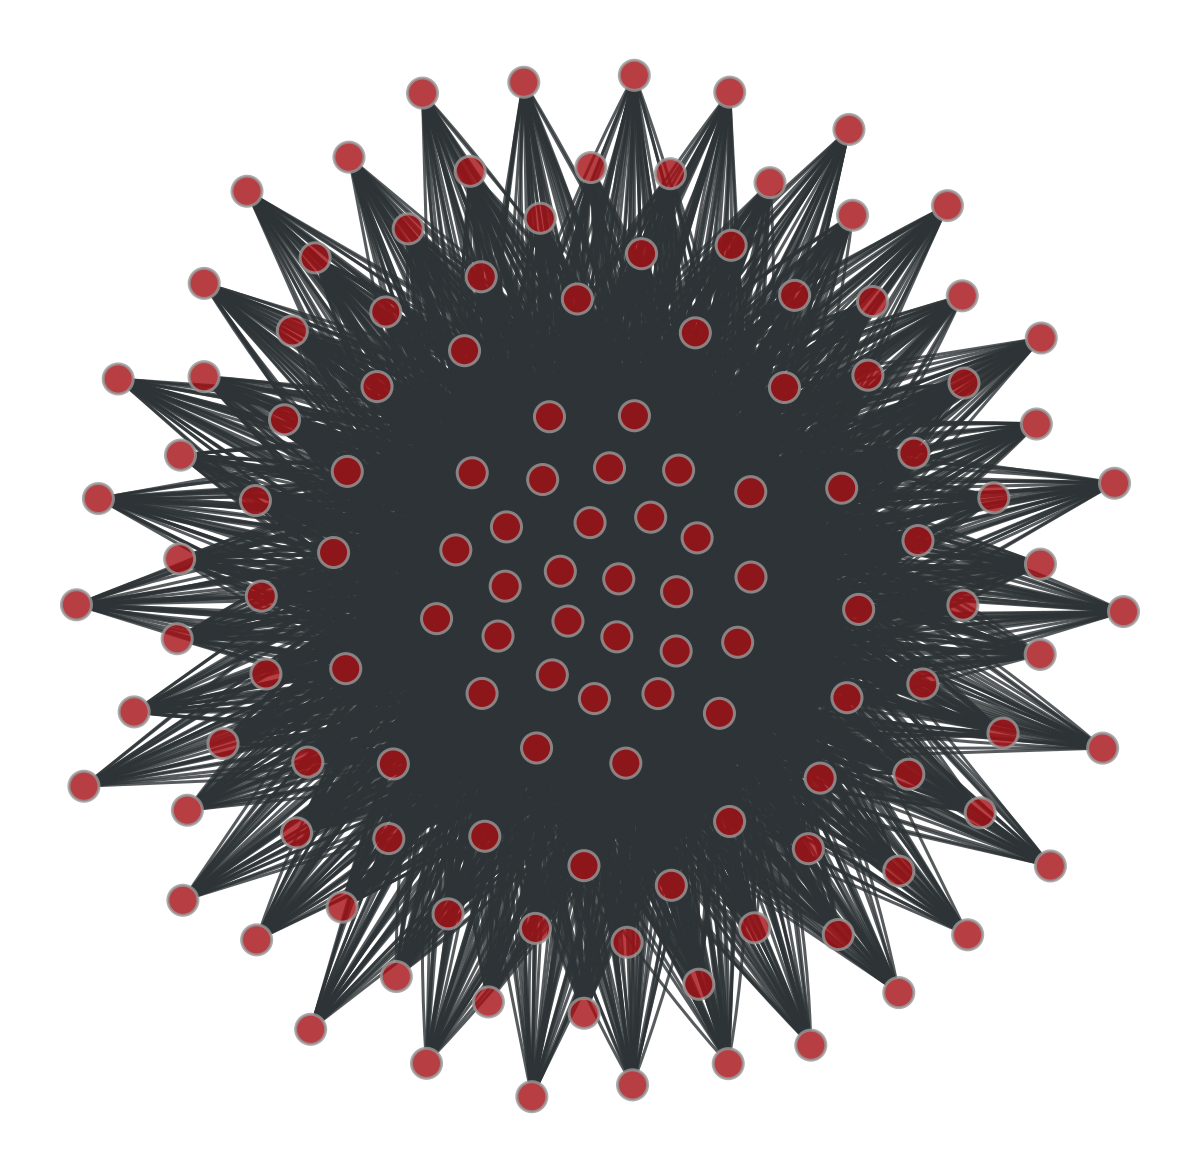

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb99d63c550, at 0x7fb9184875e0>

In [7]:
g.save("graph.xml.gz")
gt.graph_draw(g)

In [8]:
model = trisbm()
model.load_graph("graph.xml.gz")

In [9]:
model.fit()

level: 0
staging multilevel, N = 130
0 1 -0.032957 129 0.992308
bracket B = [ 3, 59, 129 ]
shrinking from: 129 -> 59
    129 -> 115: -40107.2
    115 -> 104: -38922.7
    104 -> 94: -37472.8
    94 -> 85: -36159.8
    85 -> 77: -34739.7
    77 -> 69: -32958.1
    69 -> 62: -31106.9
    62 -> 59: -30502.5
bracket B = [ 3, 59, 129 ]
shrinking from: 59 -> 3
    59 -> 53: -28619.1
    53 -> 48: -26865.4
    48 -> 43: -24401.5
    43 -> 39: -22103.2
    39 -> 35: -20002.6
    35 -> 32: -18809.5
    32 -> 29: -17316.6
    29 -> 26: -15840.4
    26 -> 23: -14134.3
    23 -> 21: -13324.7
    21 -> 19: -12100.6
    19 -> 17: -11036.3
    17 -> 15: -10105.2
    15 -> 14: -9735.49
    14 -> 13: -8982.17
    13 -> 12: -8443.58
    12 -> 11: -7644.36
    11 -> 10: -6829.94
    10 -> 9: -6642.45
    9 -> 8: -5363.45
    8 -> 7: -5257.37
    7 -> 6: -3126.28
    6 -> 5: -2955.48
    5 -> 3: -1.5199e-10
multilevel proposal: 3->129 (130), dS: -40163.3, pf: 0, pb: 0, a: inf
0 (-40163.31333287002, 1303, 

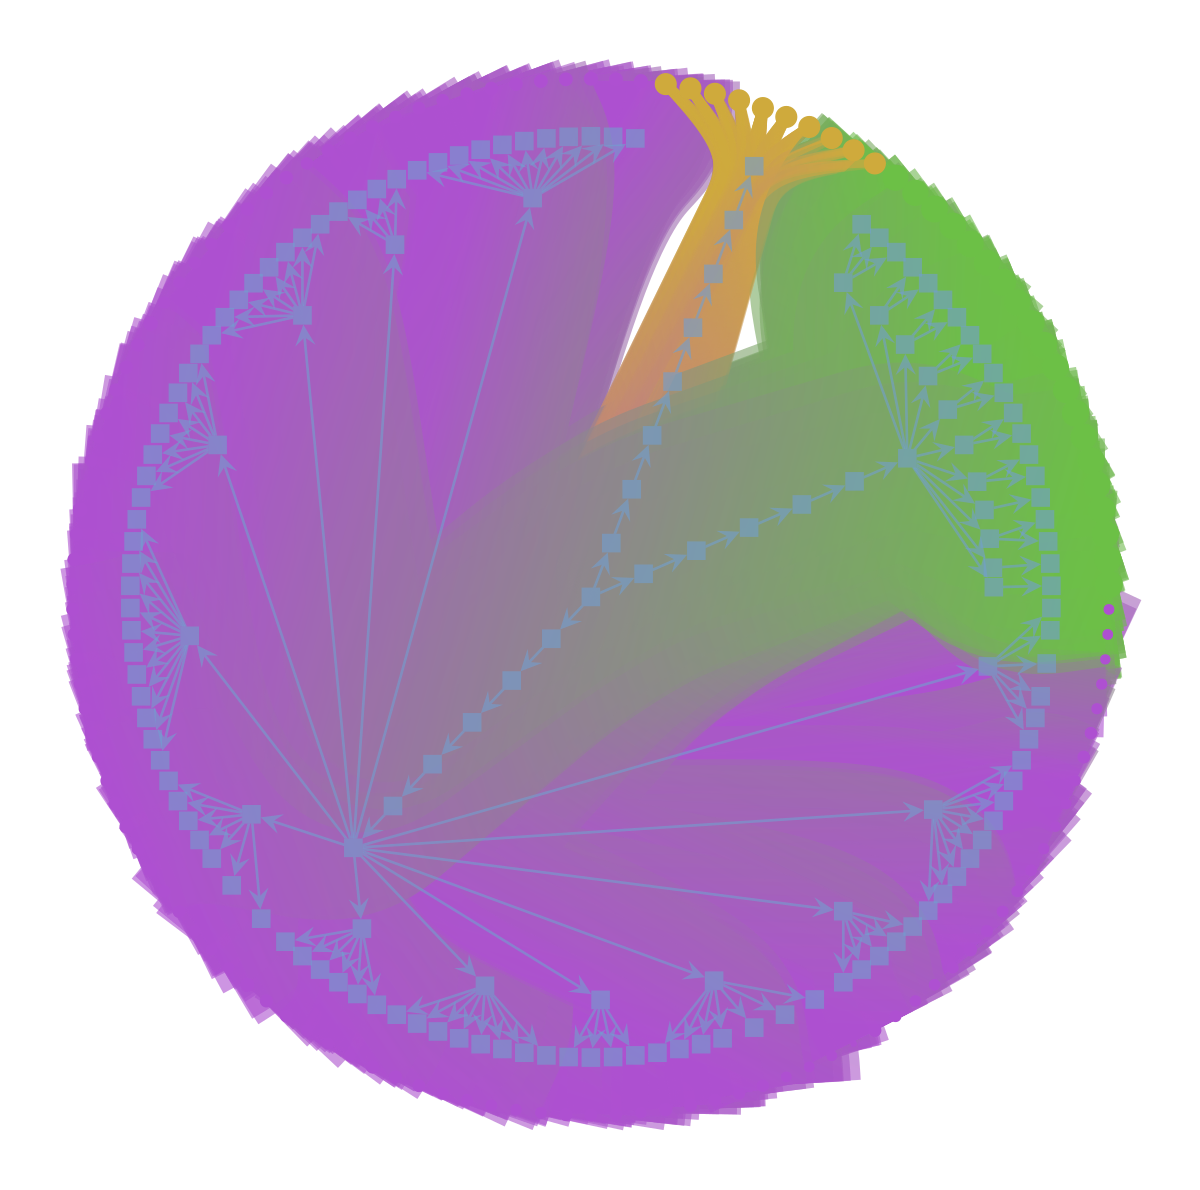

In [10]:
model.draw()

In [11]:
state = model.state.copy(bs=model.state.get_bs() + [np.zeros(1)] * 4, sampling = True)
for _ in range(100):
    state.multiflip_mcmc_sweep(beta=np.inf)

/opt/conda/lib/python3.9/site-packages/graph_tool/inference/blockmodel.py:390: UserWarning: unrecognized keyword arguments: ['sampling']
  warnings.warn("unrecognized keyword arguments: " +


In [12]:
model.state.entropy(), state.entropy()

(11294.215710902037, 11076.343732878331)

In [13]:
colmap = model.g.vertex_properties["color"] = model.g.new_vertex_property("vector<double>")

for v in model.g.vertices():
    k = model.g.vertex_properties['kind'][v]
    if k < 1:
        color = np.array([112,140,195])/255.
    elif k < 2:
        color = np.array([131,209,80])/255.
    elif k < 3:
        color = np.array([210,82,58])/255.
    else:
        color = np.array([114,124,206])/255.
    colmap[v] = color

gt.draw_hierarchy(model.state,
            layout="bipartite",
            subsample_edges=500,
            edge_pen_width=model.g.ep["count"],
            #edge_color = edge_kind,
            #edge_fill_color = edge_kind,
            hvertex_fillcolor="black",
            vertex_color=colmap,        
            vertex_fill_color=colmap,
            vertex_size=20,
            vertex_shape="square",
            output="network.png"
)

/opt/conda/lib/python3.9/site-packages/graph_tool/draw/cairo_draw.py:503: UserWarning: Unknown attribute: fillcolor
  warnings.warn("Unknown attribute: " + str(k), UserWarning)


(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb918461f70, at 0x7fb9183bf070>,
 <GraphView object, directed, with 290 vertices and 289 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fb99d3acca0, at 0x7fb9183ae820>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fb99d3acca0, at 0x7fb99d3ac5b0>, False), at 0x7fb99d3acca0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb99d3acca0, at 0x7fb99d63e670>)

# Consensus

In [14]:
pv = model.search_consensus(force_niter=10, niter=5)

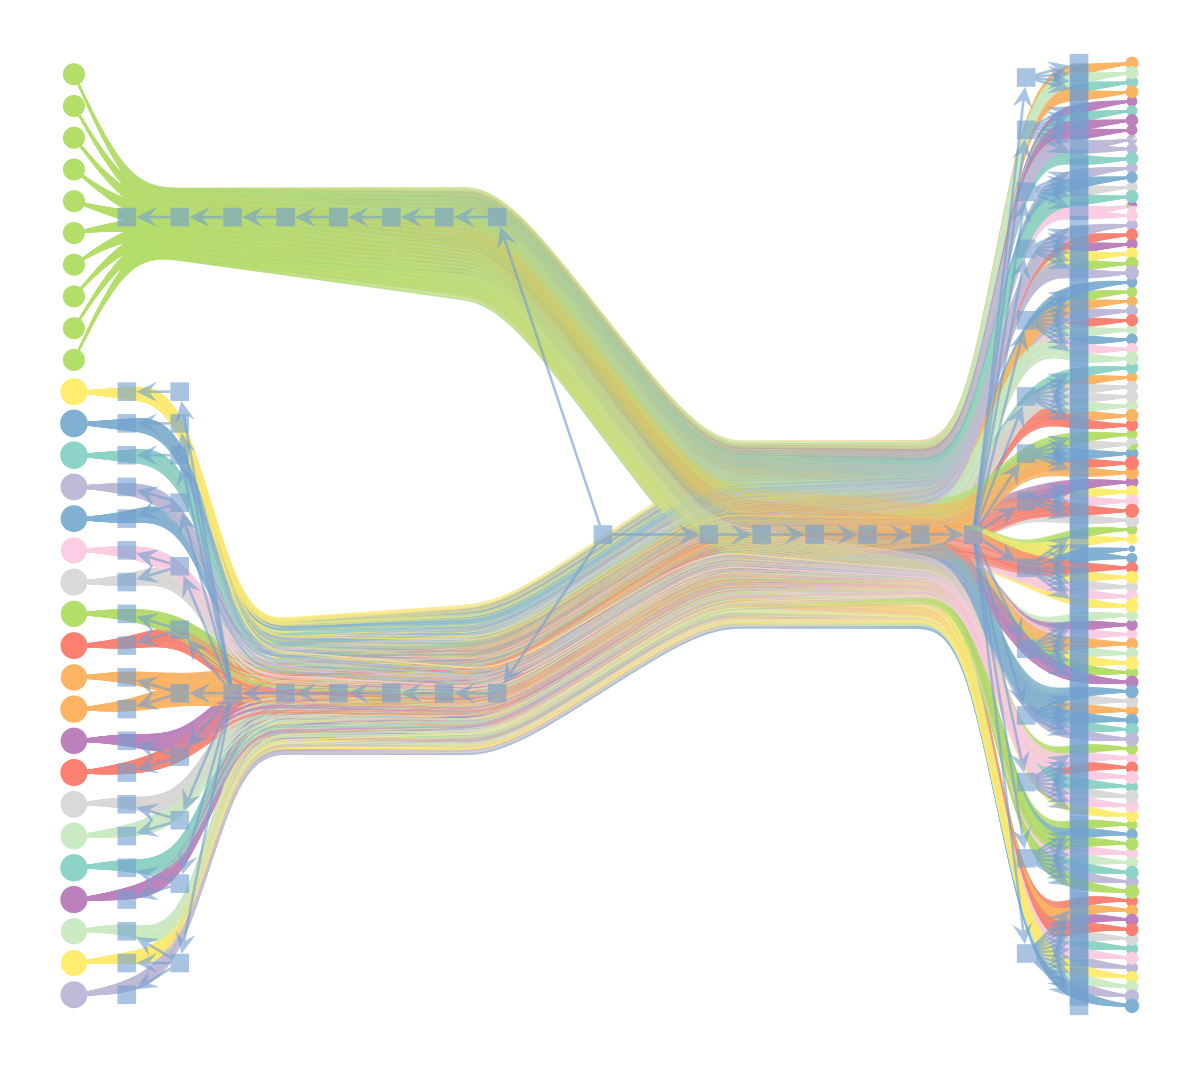

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb918461f70, at 0x7fb9183bf8e0>,
 <GraphView object, directed, with 293 vertices and 292 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fb9183bf100, at 0x7fb99d3bdf40>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fb9183bf100, at 0x7fb99d3bd2e0>, False), at 0x7fb9183bf100>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb9183bf100, at 0x7fb9183942b0>)

In [15]:
# We can visualize the marginals as pie charts on the nodes:
model.state.draw(layout="bipartite", 
            subsample_edges=5000,
            vertex_shape="pie", 
            vertex_pie_fractions=pv,
            #output="network_consensus.pdf"
            )